# CreditCard Fraud Detection

# Get the dataset 

In [1]:
import pandas as pd
df = pd.read_csv("creditcard.csv")
print(df.head())
print(df["Class"].value_counts())  # Check imbalance: 0 (non-fraud), 1 (fraud)


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

# Exploratory Data Analysis (EDA)

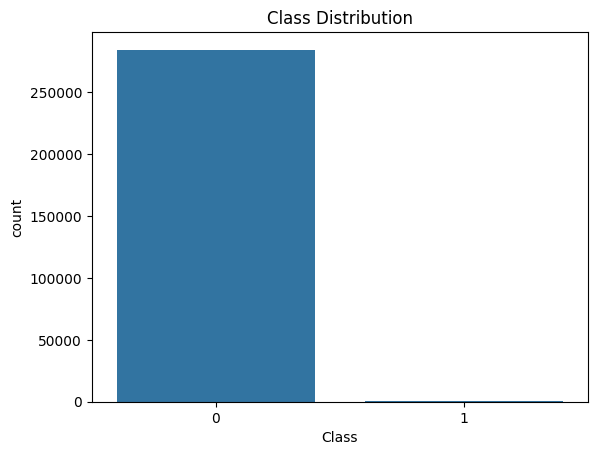

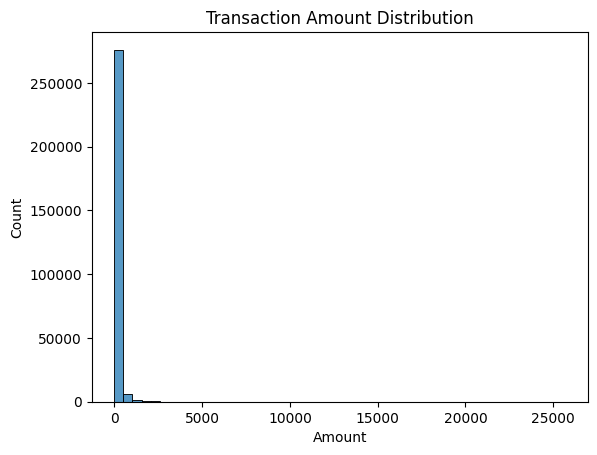

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x="Class", data=df)
plt.title("Class Distribution")
plt.show()
sns.histplot(df["Amount"], bins=50)
plt.title("Transaction Amount Distribution")
plt.show()

# Handle Missing Values

In [3]:
print(df.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


# Scale Features --> Standardize Amount and Time

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df["Scaled_Amount"] = scaler.fit_transform(df[["Amount"]])
df["Scaled_Time"] = scaler.fit_transform(df[["Time"]])
df.drop(["Amount", "Time"], axis=1, inplace=True)

# Address Imbalance (critical for fraud detection)

In [5]:
from imblearn.over_sampling import SMOTE
X = df.drop("Class", axis=1)
y = df["Class"]
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print(pd.Series(y_resampled).value_counts())  # Balanced classes

Class
0    284315
1    284315
Name: count, dtype: int64


# Model Building

# Precision (to avoid false positives) , Recall (to catch frauds), F1-score, and ROC-AUC (crucial for imbalanced data)

In [6]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report, roc_auc_score

# Load and sample data
df = pd.read_csv("creditcard.csv")
df_sample = df.sample(frac=0.1, random_state=42)  # 10% of data

# Undersample majority class
df_majority = df_sample[df_sample["Class"] == 0]
df_minority = df_sample[df_sample["Class"] == 1]
df_majority_downsampled = resample(df_majority, n_samples=len(df_minority), random_state=42)
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Prepare features
X = df_balanced.drop("Class", axis=1)
y = df_balanced["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train optimized Random Forest
model = RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42, verbose=1)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])}")

              precision    recall  f1-score   support

           0       0.80      1.00      0.89        12
           1       1.00      0.57      0.73         7

    accuracy                           0.84        19
   macro avg       0.90      0.79      0.81        19
weighted avg       0.87      0.84      0.83        19

ROC-AUC: 0.9523809523809523


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.0s finished


# XGBoost Model for comparison

In [7]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89        12
           1       1.00      0.57      0.73         7

    accuracy                           0.84        19
   macro avg       0.90      0.79      0.81        19
weighted avg       0.87      0.84      0.83        19



# Tuning

In [8]:
from sklearn.model_selection import GridSearchCV
param_grid = {"n_estimators": [50, 100], "max_depth": [5, 10]}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring="roc_auc")
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'max_depth': 5, 'n_estimators': 50}


# Visualize which Features

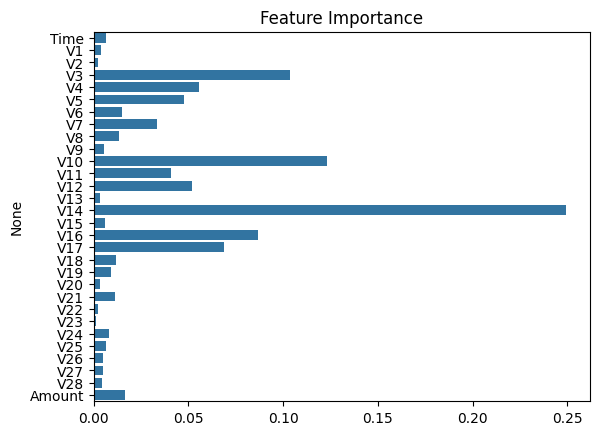

In [9]:
importances = model.feature_importances_
sns.barplot(x=importances, y=X_train.columns)
plt.title("Feature Importance")
plt.show()

# Show True Positives (Frauds Caught) and False Positives

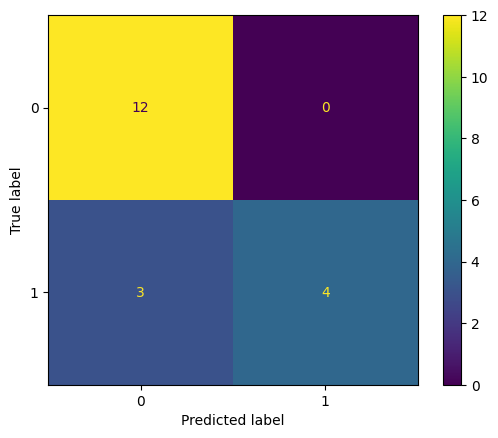

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

# ROC curve to Visualize Model Performance

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.0s finished


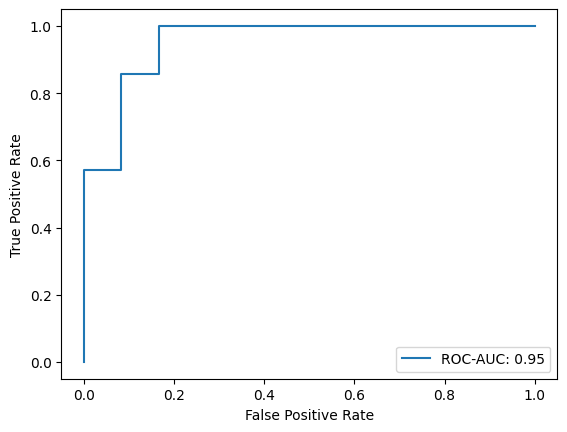

In [11]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label=f"ROC-AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()